In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
from torchvision import datasets, transforms

In [2]:
def soft_threshold(x, lambd):
    return torch.sign(x) * torch.max(torch.abs(x) - lambd, torch.zeros_like(x))

def hard_threshold(x, lambd):
    return x * (torch.abs(x) > lambd).float()

In [3]:
# MLCSC6 returns the reconstructed image from the latent space (n_batch, 1024, 2, 2)
class MLCSC6(nn.Module):
    def __init__(self, n_layers = 6):
        super(MLCSC6, self).__init__()
        
        D1 = nn.ConvTranspose2d(128, 1, kernel_size=2, stride=2, padding=0)
        D2 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=0)
        D3 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=0)
        D4 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=0)
        D5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=0)
        D6 = nn.ConvTranspose2d(256, 256, kernel_size=5, stride=1, padding=0)
        
        #self.layers = [D6, D5, D4, D3, D2, D1]
        self.layers = [D6, D5, D4, D3, D2, D1]
        self.n_layers = n_layers
        self.layers = nn.ModuleList(self.layers[6-n_layers:])
        self.strides = [1, 1, 1, 1, 1, 2][6-n_layers:]
        self.ksizes = [5, 3, 3, 3, 3, 6][6-n_layers:]
    
    def F(self, x, lambd = 0.1):
        return torch.div(torch.square(x).flatten(1).sum(1), 2) + lambd * torch.abs(x).flatten(1).sum(1)
    
    def initialize(self, x):
        
        for i in range(self.n_layers-1, -1, -1):
            x = F.conv2d(x, self.layers[i].weight, stride=self.strides[i], padding=0)
            #x = self.layers[i](x)
            #print(x.shape)
        #pass
        return x
    
    def FISTA(self, x, y, lambd = 0.03, n_iter = 20):
        batch_size = x.size(0)
        Dx = self.forward(x)
        
        gradient = Dx-y
        for i in range(self.n_layers, 0, -1):
            gradient = F.conv2d(gradient, self.layers[i-1].weight, stride=self.strides[i-1], padding=0)
        tk, tk_next = torch.tensor(1., device = x.device), torch.tensor(1., device = x.device)
        loss_list = []
        for _ in range(n_iter):
            z = x.clone()
            const = self.F(z, lambd).reshape(-1, 1, 1, 1)
            
            L = torch.ones((batch_size, 1, 1, 1), device = x.device)
            stop_line_search = torch.zeros((batch_size), device=x.device).bool()
            while torch.sum(stop_line_search) < batch_size:
                # line search
                # print(z.shape, gradient.shape, L.shape)
                prox_z = soft_threshold(z - torch.div(gradient, L), torch.div(lambd, L))
                
                # check descent condition
                temp1 = self.F(prox_z, lambd).reshape(-1, 1, 1, 1)
                temp2 = const + torch.mul(gradient, prox_z - z).flatten(1).sum(1).reshape(-1, 1, 1, 1) + \
                                torch.div(L, 2) * torch.square(prox_z - z).flatten(1).sum(1).reshape(-1, 1, 1, 1)
                stop_line_search = temp1 <= temp2
                L = torch.where(stop_line_search, L, 2 * L)
            
            tk_next = (1 + torch.sqrt(1 + 4 * tk**2)) / 2
            x = prox_z + torch.div(tk - 1, tk_next) * (prox_z - z)
            tk = tk_next
            loss_list.append(torch.mean(self.F(x, lambd)).item())
        
        return x, loss_list
    
    def IHT(self, lambds):
        # lambd2, lambd3 = 0.005, 0.01#0.01, 0.005, 0.01
        # self.layer1.weight = hard_threshold(self.layer1.weight, lambd1)
        # self.layer2.weight = nn.Parameter(hard_threshold(self.layer2.weight, lambd2))
        # self.layer3.weight = nn.Parameter(hard_threshold(self.layer3.weight, lambd3))
        for i in range(1, self.n_layers):
            self.layers[i].weight = nn.Parameter(hard_threshold(self.layers[i].weight, lambds[i-1]))
            #print(torch.sum(self.layers[i].weight.flatten()==0) / torch.numel(self.layers[i].weight))
    
    def forward(self, x):
        for i in range(self.n_layers):
            x = self.layers[i](x)
        
        return x
    


In [18]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLCSC6().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)

for epoch in range(1, 21):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        
        with torch.no_grad():
            code = model.initialize(data)
            #x = torch.randn_like(code, device=device)
            x, _ = model.FISTA(code, data, 0.1, 20)
        optimizer.zero_grad()
        x = x.clone().requires_grad_(True)
        output = model(x)
        loss = F.mse_loss(output, data)# + 0.001 * (torch.norm(model.layer2.weight, 'fro') + torch.norm(model.layer3.weight, 'fro') + torch.norm(model.layer1.weight, 'fro'))
        loss.backward()
        optimizer.step()
        
        # iterative hard thresholding step
        #model.IHT()
        model.IHT([0.001, 0.005, 0.01, 0.02, 0.1])
        #model.normalize_weights()
        if batch_idx % 100 == 0:
            l1_ratio = [(torch.sum(model.layers[i].weight.flatten()==0) / torch.numel(model.layers[i].weight)).item() for i in range(1, model.n_layers)]
            print("loss", "{:.4f}".format(loss.item()), "sparsity:", ["{0:0.2f}".format(i) for i in l1_ratio])
    print(f'epoch {epoch}, loss {loss.item()}\n')

loss 1.1596 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.2817 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.2769 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.2573 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.2320 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.2153 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.2146 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.2028 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.1875 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.1773 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.1705 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.1704 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.1630 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.1592 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.1467 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.16']
loss 0.1534 sparsity: ['0.03', '0.17', '0.34', '0.68', 

In [5]:
code.shape

torch.Size([100, 256, 2, 2])

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLCSC6().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)

for epoch in range(1, 21):
    loss_list = []
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        
        with torch.no_grad():
            # code = model.initialize(data)
            code = torch.randn((100, 256, 2, 2), device=device)
            x, _ = model.FISTA(code, data, 0.1, 20)
        optimizer.zero_grad()
        x = x.clone().requires_grad_(True)
        output = model(x)
        loss = F.mse_loss(output, data)# + 0.001 * (torch.norm(model.layer2.weight, 'fro') + torch.norm(model.layer3.weight, 'fro') + torch.norm(model.layer1.weight, 'fro'))
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        # iterative hard thresholding step
        #model.IHT()
        with torch.no_grad():
            model.IHT([0.001, 0.005, 0.01, 0.02, 0.2])
        #model.normalize_weights()
        if batch_idx % 100 == 0:
            l1_ratio = [(torch.sum(model.layers[i].weight.flatten()==0) / torch.numel(model.layers[i].weight)).item() for i in range(1, model.n_layers)]
            print("loss", "{:.4f}".format(loss.item()), "sparsity:", ["{0:0.2f}".format(i) for i in l1_ratio])
    print(f'epoch {epoch}, loss {np.mean(loss_list)}\n')

loss 0.5299 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
loss 0.2269 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
loss 0.1896 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
loss 0.1816 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
loss 0.1956 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
loss 0.1882 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
epoch 1, loss 0.2050610444446405

loss 0.1821 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
loss 0.1875 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
loss 0.1780 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
loss 0.1856 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
loss 0.1831 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
loss 0.1891 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
epoch 2, loss 0.18365054282049337

loss 0.1852 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
loss 0.1951 sparsity: ['0.03', '0.17', '0.34', '0.68', '0.40']
loss 0.1903 sparsity: ['0.03', '0.17', '0.34', '0

KeyboardInterrupt: 

In [19]:
torch.save(model.state_dict(), f'model_MNIST6.pt')

0.020546875


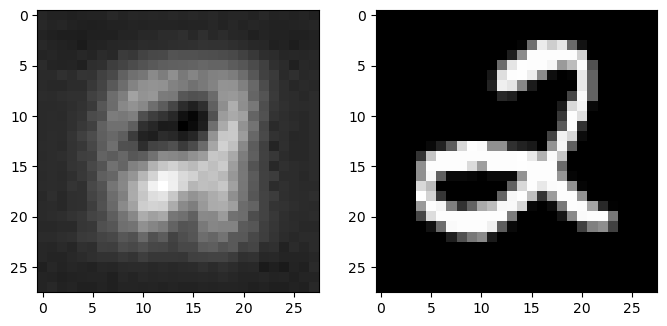

In [7]:
output.shape
idx = 56
#plt.imshow(output[idx].cpu().detach().numpy().reshape(28, 28), cmap='gray')
#plt.show()
#plt.imshow(data[idx].cpu().detach().numpy().reshape(28, 28), cmap='gray')

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(output[idx].cpu().detach().numpy().reshape(28, 28), cmap='gray')
ax[1].imshow(data[idx].cpu().detach().numpy().reshape(28, 28), cmap='gray')
'''
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].hist(model.layer2.weight.cpu().detach().numpy().flatten(), bins=200)
ax[1].hist(model.layer3.weight.cpu().detach().numpy().flatten(), bins=200)
ax[2].hist(x.cpu().detach().numpy().flatten(), bins=200)
plt.show()
'''
print(np.sum(x.cpu().detach().numpy().flatten()==0) / x.cpu().detach().numpy().size)

In [8]:
output_list_train = []
label_list_train = []
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=False)
for batch_idx, (data, label) in enumerate(train_loader):
    data = data.to(device)
    print(batch_idx)
    with torch.no_grad():
        code = model.initialize(data)
        x = torch.randn_like(code, device=device)
        x, _ = model.FISTA(code, data, 0.1, 20)
        # x = x.clone()
        output = model(x)
        output_list_train.append(output.cpu().detach().numpy())
        label_list_train.append(label.cpu().detach().numpy())
        
output_list_train = np.concatenate(output_list_train, axis=0)
print(output_list_train.shape)
label_list_train = np.concatenate(label_list_train, axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [9]:
#label_list_train = np.stack(label_list_train, axis=0)
print(label_list_train.shape)

(60000,)


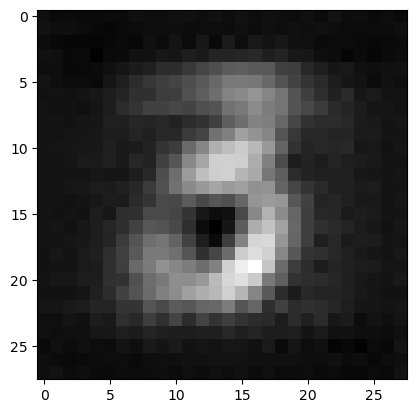

3


In [11]:
idx = 1234

plt.imshow(output_list_train[idx].reshape(28, 28), cmap='gray')
plt.show()
print(label_list_train[idx])
#torch.save(output_list_train, 'data/output_MNIST6_train.pt')
#torch.save(label_list_train, 'data/label_MNIST6_train.pt')

In [12]:
output_list_test = []
label_list_test = []
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)
for batch_idx, (data, label) in enumerate(test_loader):
    data = data.to(device)
    print(batch_idx)
    with torch.no_grad():
        code = model.initialize(data)
        x = torch.randn_like(code, device=device)
        x, _ = model.FISTA(code, data, 0.1, 20)
        # x = x.clone()
        output = model(x)
        output_list_test.append(output.cpu().detach().numpy())
        label_list_test.append(label.cpu().detach().numpy())
        
output_list_test = np.concatenate(output_list_test, axis=0)
print(output_list_test.shape)
label_list_test = np.concatenate(label_list_test, axis=0)
print(label_list_test.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
(10000, 1, 28, 28)
(10000,)


In [19]:
#label_list_test = np.concatenate(label_list_test, axis=0)
print(label_list_test.shape)

(10000,)


In [83]:
print(output_list_test.shape)
print(label_list_test.shape)
torch.save(output_list_test, 'data/output_MNIST6_test.pt')
torch.save(label_list_test, 'data/label_MNIST6_test.pt')

(10000, 1, 28, 28)
(10000,)


In [30]:
output_list_train = torch.load('data/output_MNIST6_train.pt')
label_list_train = torch.load('data/label_MNIST6_train.pt')
output_list_test = torch.load('data/output_MNIST6_test.pt')
label_list_test = torch.load('data/label_MNIST6_test.pt')

tensor(-1.) tensor(1.)
5
torch.Size([1, 28, 28])


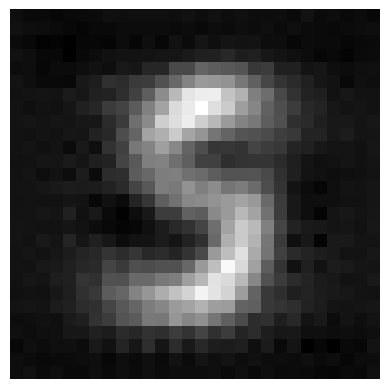

In [13]:
# write a data loader for train_data and test_data
stats = ((0.5), (0.5))
class SparseDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, train=True):
        self.data = data
        self.labels = labels
        if not train:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                  transforms.Normalize(*stats,inplace=True),
                                                ])
        else:
            self.transform = transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.RandomCrop(28, padding=4, padding_mode='reflect'),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.Normalize(*stats,inplace=True),
                                                ])
    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]
        img = (img - img.min())/(img.max() - img.min())
        #else:
        #    img = img
        # img = (img - img.min())/(img.max() - img.min())
        img = self.transform(img.transpose(1,2,0))
        return img, label

    def __len__(self):
        return len(self.data)
    
train_sparse_dataset = SparseDataset(output_list_train, label_list_train, train=False)
display, label = next(iter(train_sparse_dataset))
plt.imshow(display.permute(1,2,0), cmap='gray')
plt.axis('off')
print(display.min(), display.max())
print(label)
print(display.shape)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [15]:
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = ResNet9()
net = net.to(device)
# batch_size = 4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_sparse = SparseDataset(output_list_train, label_list_train, train=True)
train_loader = DataLoader(train_sparse, batch_size=128, shuffle=True, num_workers=4)
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.type(torch.LongTensor).cuda())
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
        


print('Finished Training')

[1,   200] loss: 0.698
[1,   400] loss: 0.338
[2,   200] loss: 0.267
[2,   400] loss: 0.244
[3,   200] loss: 0.207
[3,   400] loss: 0.197
[4,   200] loss: 0.176
[4,   400] loss: 0.187
[5,   200] loss: 0.165
[5,   400] loss: 0.167
[6,   200] loss: 0.155
[6,   400] loss: 0.145
[7,   200] loss: 0.140
[7,   400] loss: 0.139
[8,   200] loss: 0.132
[8,   400] loss: 0.136
[9,   200] loss: 0.130
[9,   400] loss: 0.125
[10,   200] loss: 0.118
[10,   400] loss: 0.121
[11,   200] loss: 0.111
[11,   400] loss: 0.118
[12,   200] loss: 0.110
[12,   400] loss: 0.107
[13,   200] loss: 0.101
[13,   400] loss: 0.102
[14,   200] loss: 0.094
[14,   400] loss: 0.103
[15,   200] loss: 0.090
[15,   400] loss: 0.098
[16,   200] loss: 0.085
[16,   400] loss: 0.089
[17,   200] loss: 0.081
[17,   400] loss: 0.087
[18,   200] loss: 0.074
[18,   400] loss: 0.083
[19,   200] loss: 0.076
[19,   400] loss: 0.080
[20,   200] loss: 0.071
[20,   400] loss: 0.082
[21,   200] loss: 0.068
[21,   400] loss: 0.074
[22,   200

In [16]:
test_sparse = SparseDataset(output_list_test, label_list_test, train=False)
test_loader = DataLoader(test_sparse, batch_size=128, shuffle=False, num_workers=4)

correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.type(torch.LongTensor).cuda()).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 97.14%


In [11]:
inputs.shape

torch.Size([128, 1, 32, 32])

In [12]:
images.shape

torch.Size([128, 1, 28, 28])

In [82]:
images.shape

torch.Size([128, 1, 28, 28])